In [1]:
#Reinforcement Learning implementation for Cliff Walking problem
#Written by Morteza Sadeghi- morteza.sadeghi@mat.ethz.ch
import numpy as np
import copy
import collections as coll
import random
import tensorflow as tf
import time

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [2]:
height=10
width=10
state_size=2
learning_rate=0.001
num_episodes = 2000
num_timesteps = 1000
max_len_memory_buffer=100000
num_steps_update=4
mini_batch_size=64
gama=0.995
tau=0.001
epsilon_min=0.01
epsilon_coeff=0.995
num_ave=100
epsilon=1

In [3]:

class Agent:
    def __init__(self,state_size,learning_rate):
        
        self.action_space=["U","D","R","L"]
        self.action_size=len(self.action_space)
        self.state_size=state_size
        
        self.q_network=Sequential([Input(shape=self.state_size),                      
        Dense(units=64, activation='relu'),            
        Dense(units=64, activation='relu'),            
        Dense(units=self.action_size, activation='linear'),])
        
        self.target_q_network = Sequential([
        Input(shape=state_size),                       
        Dense(units=64, activation='relu'),            
        Dense(units=64, activation='relu'),            
        Dense(units=self.action_size, activation='linear'), 
        ])
        
        self.target_q_network.set_weights(self.q_network.get_weights())
        
        self.optimizer = Adam(learning_rate=learning_rate) 
        
      
    def choose_action(self,epsilon,qvalues):
        if np.random.random() < epsilon:
            return np.random.choice(range(self.action_size))
        else:
            return np.argmax(qvalues)
        
  
    def loss_func(self,experiences,gama):
        
        
        states=np.array([e.state for e in experiences])
        actions=np.array([e.action for e in experiences])
        rewards=np.array([e.reward for e in experiences])
        next_states=np.array([e.next_state for e in experiences])
        done_vals=np.array([e.done for e in experiences]).astype('int')
        
               
        states=tf.convert_to_tensor(states,dtype=tf.float32)
        actions=tf.convert_to_tensor(actions,dtype=tf.float32)
        rewards=tf.convert_to_tensor(rewards,dtype=tf.float32)
        next_states=tf.convert_to_tensor(next_states,dtype=tf.float32)
        done_vals=tf.convert_to_tensor(done_vals,dtype=tf.float32)
        
        y_values=rewards+(1-done_vals)*(gama*tf.reduce_max(self.target_q_network(next_states),axis=1))
        
        q_values = self.q_network(states)
        q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
            
       
        loss=MSE(q_values,y_values) 
        return loss
    

    def learn(self,experiences,gama,tau):
        with tf.GradientTape() as tape:
            loss=self.loss_func(experiences,gama)
 
        gradients = tape.gradient(loss, self.q_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.q_network.trainable_variables))
        
        target_weights=self.target_q_network.get_weights()
        weights=self.q_network.get_weights()
        
        for i in range(len(weights)):
             target_weights[i]=weights[i]*tau+target_weights[i]*(1-tau)
        
        self.target_q_network.set_weights(target_weights)        
         

In [4]:
class environment:
    def __init__(self,height,width,state_size):
        self.height=height
        self.width=width
        self.state_size=state_size
        self.max_step=1000
    def reset(self):
        state=np.zeros(2)
        state[0]=1
        state[1]=1
        return state      
    def step(self,action,state):
        next_state=np.zeros(2)
        next_state=copy.deepcopy(state)
        if ((action==0) and (state[0]<self.height)):
            next_state[0]=state[0]+1
            reward=-1
        elif ((action==0) and (state[0]==self.height)):
            reward=-10
        elif ((action==1) & (state[0]>1)):
            next_state[0]=state[0]-1
            reward=-1
        elif ((action==1) & (state[0]==1)):
            reward=-10
        elif ((action==2) & (state[1]<self.width)): 
            next_state[1]=state[1]+1
            reward=-1
        elif ((action==2) & (state[1]==self.width)):  
            reward=-10
        elif ((action==3) & (state[1]>1)):
            next_state[1]=state[1]-1
            reward=-1
        elif ((action==3) & (state[1]==1)): 
            reward=-10
            
        if (next_state[0]==1) & (next_state[1]!=1) & (next_state[1]!=self.width):
            reward=-100
        elif (next_state[0]==1) & (next_state[1]==self.width):
            reward=100
 
        done=False    
        if ((next_state[0]==1) & (next_state[1]>1)):
            done=True
        return next_state,reward,done  

In [5]:
experience=coll.namedtuple("experience",field_names=['state','action','reward','next_state','done'])

In [6]:
env=environment(height,width,state_size)
state=env.reset()
print(env.step(2,state))

(array([1., 2.]), -100, True)


In [7]:
start = time.time()
memory_buffer=coll.deque(maxlen=max_len_memory_buffer)
agent=Agent(state_size,learning_rate)

history=[]
for i in range(num_episodes):
    state=env.reset()
    total_points=0
    
    for j in range(num_timesteps):
        state_qn=np.expand_dims(state,axis=0)
        q_values=agent.q_network(state_qn)
    
        
        action=agent.choose_action(epsilon,q_values)
    
        next_state,reward,done=env.step(action,state)
        memory_buffer.append(experience(state,action,reward,next_state,done))
        
        if ((j+1)%num_steps_update==0) & (len(memory_buffer)>mini_batch_size):
            experiences_for_learn=random.sample(memory_buffer,mini_batch_size)
            
            agent.learn(experiences_for_learn,gama,tau)
    
        state=copy.deepcopy(next_state)
        total_points=total_points+reward
        
        if done:
            break
                  
    history.append(total_points)
    
    epsilon=max(epsilon_min,epsilon*epsilon_coeff)
    
    ave_latest_point=np.mean(history[-num_ave:])
    
    if (i+1) % num_ave == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_ave} episodes: {ave_latest_point:.2f}")
    
    if (ave_latest_point>85):
        print(f"\n Environment solved in {i+1} number of Episodes, and the total point average of the last {num_ave} episodes is {ave_latest_point:.2f}. Enjoy!")
        break
        
duration=time.time()-start
print(f"total time of simulation: {duration}")

Episode 100 | Total point average of the last 100 episodes: -466.71
Episode 200 | Total point average of the last 100 episodes: -500.04
Episode 300 | Total point average of the last 100 episodes: -288.14
Episode 400 | Total point average of the last 100 episodes: -436.14
Episode 500 | Total point average of the last 100 episodes: -333.45
Episode 600 | Total point average of the last 100 episodes: -396.02
Episode 700 | Total point average of the last 100 episodes: -132.74
Episode 800 | Total point average of the last 100 episodes: -40.81
Episode 900 | Total point average of the last 100 episodes: -23.31
Episode 1000 | Total point average of the last 100 episodes: 8.34
Episode 1100 | Total point average of the last 100 episodes: 27.88
Episode 1200 | Total point average of the last 100 episodes: 22.39
Episode 1300 | Total point average of the last 100 episodes: 33.45
Episode 1400 | Total point average of the last 100 episodes: 61.51
Episode 1500 | Total point average of the last 100 episo

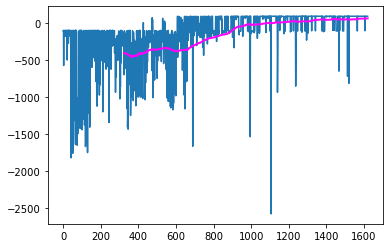

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
total_episodes=len(history)
plt.plot(range(total_episodes),history)
size=total_episodes//5
rolling_mean = pd.DataFrame(history).rolling(size).mean()
plt.plot(range(total_episodes), rolling_mean, linewidth=2, color="magenta")